In [20]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as npr
import scipy.optimize as optimization
import datetime
from scipy.stats import norm
from scipy import stats
from numpy import log, exp, sqrt
from numpy.random import normal

# Bonds

In [2]:
class ZeroCouponBonds:
    
    def __init__(self, principal, maturity, interest_rate):
        # principal amount
        self.principal = principal
        # date to maturity
        self.maturity = maturity
        # market interest rate (discounting)
        self.interest_rate = interest_rate / 100
        
    def present_value(self, x, n):
        return x / (1+self.interest_rate)**n
    
    def calculate_price(self):
        return self.present_value(self.principal, self.maturity)
    
if __name__ == '__main__':
    
    bond = ZeroCouponBonds(1000, 2, 4)
    print("Price of the bond in dollars: %.2f" % bond.calculate_price())

Price of the bond in dollars: 924.56


In [3]:
class CouponBond:
    
    def __init__(self, principal, rate, maturity, interest_rate):
        self.principal = principal
        self.rate = rate /100
        self.maturity = maturity
        self.interest_rate = interest_rate / 100
        
    def present_value(self, x, n):
        return x / (1+self.interest_rate)**n
    
    def calculate_price(self):
        
        price = 0
        
        # discount the coupon payments
        for t in range(1, self.maturity+1):
            price = price + self.present_value(self.principal * self.rate, t)
            
        # discount principal amount
        price = price + self.present_value(self.principal, self.maturity)
        
        return price
    
if __name__ == '__main__':
    
    bond = CouponBond(1000, 10, 3, 4)
    print("Bond price: %.2f" % bond.calculate_price())

Bond price: 1166.51


# Markowitz Model

In [4]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252
# we will generate random weights (different portfolios)
NUM_PORTFOLIOS = 10000

# stocks we are going to handle
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

In [5]:
# historical data - define START and END dates
start_date = '2016-01-01'
end_date = '2023-01-01'

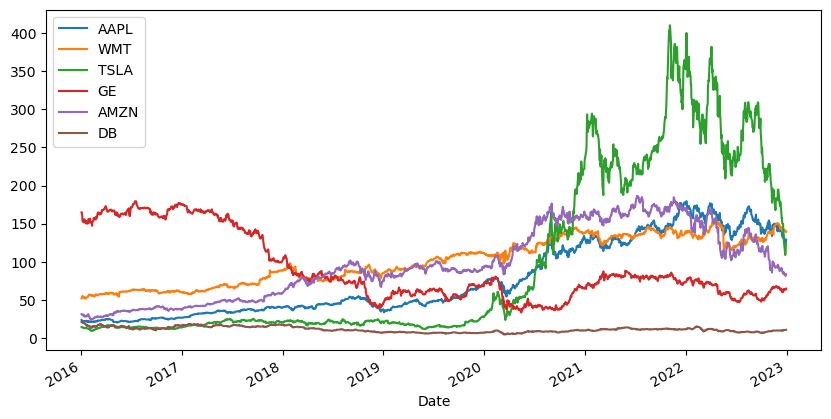

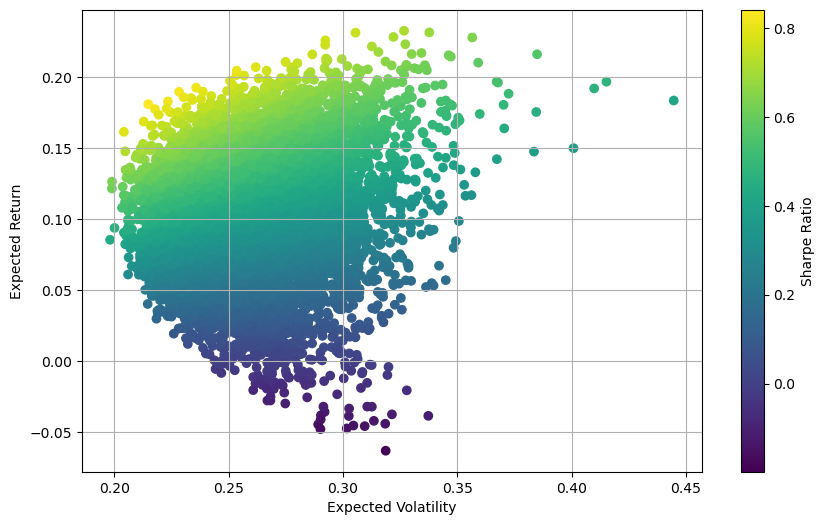

Optimal portfolio:  [0.461 0.457 0.083 0.    0.    0.   ]
Expected return, volatility and Sharpe ratio [0.20039581 0.22264175 0.90008192]


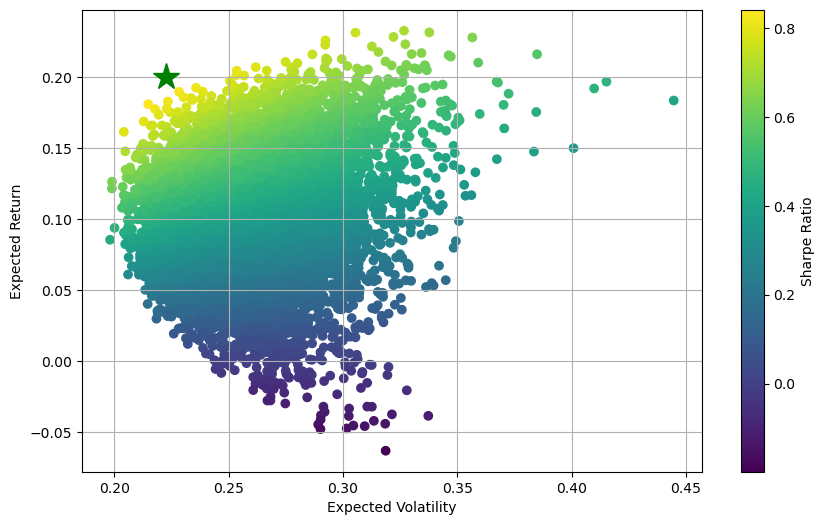

In [6]:
def download_data():
    # name of the stock (key) - stock values (2016-2023) as the values
    stock_data = {}
    
    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
        
    return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10,5))
    plt.show()

def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data/data.shift(1))
    return log_return[1:]

def show_statistics(returns):
    # instead of daily metrics we are after annual etrics
    # mean of annual return
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)

def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()
    
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []
    
    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))
    
    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

# scipy optimize module can find the minimum of a given function
# the maximum of f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

# what are the constraints? The sum of weights is 1
# when f(x)=0, we want to minimize the function f
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type':'eq','fun':lambda x: np.sum(x)-1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0,1) for _ in range(len(stocks)))
    return optimization.minimize(fun = min_function_sharpe, x0 = weights[0], args = returns, method = 'SLSQP', bounds = bounds, constraints = constraints)

def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio", statistics(optimum['x'].round(3),returns))

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(optimum['x'], rets)[0], 'g*', markersize = 20.0)
    plt.show()    
    
if __name__ == '__main__':
    
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)
    
    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

# Capital Asset Pricing Model

In [8]:
# market interest rate
RISK_FREE_RATE = 0.05
# we will consider monthly returns - and we want to calculate the annual return
MONTHS_IN_YEAR = 12

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Beta from formula 0.8856503116941531
Beta from regression:  0.8856503116941528
Expected return: 0.06106404064094721


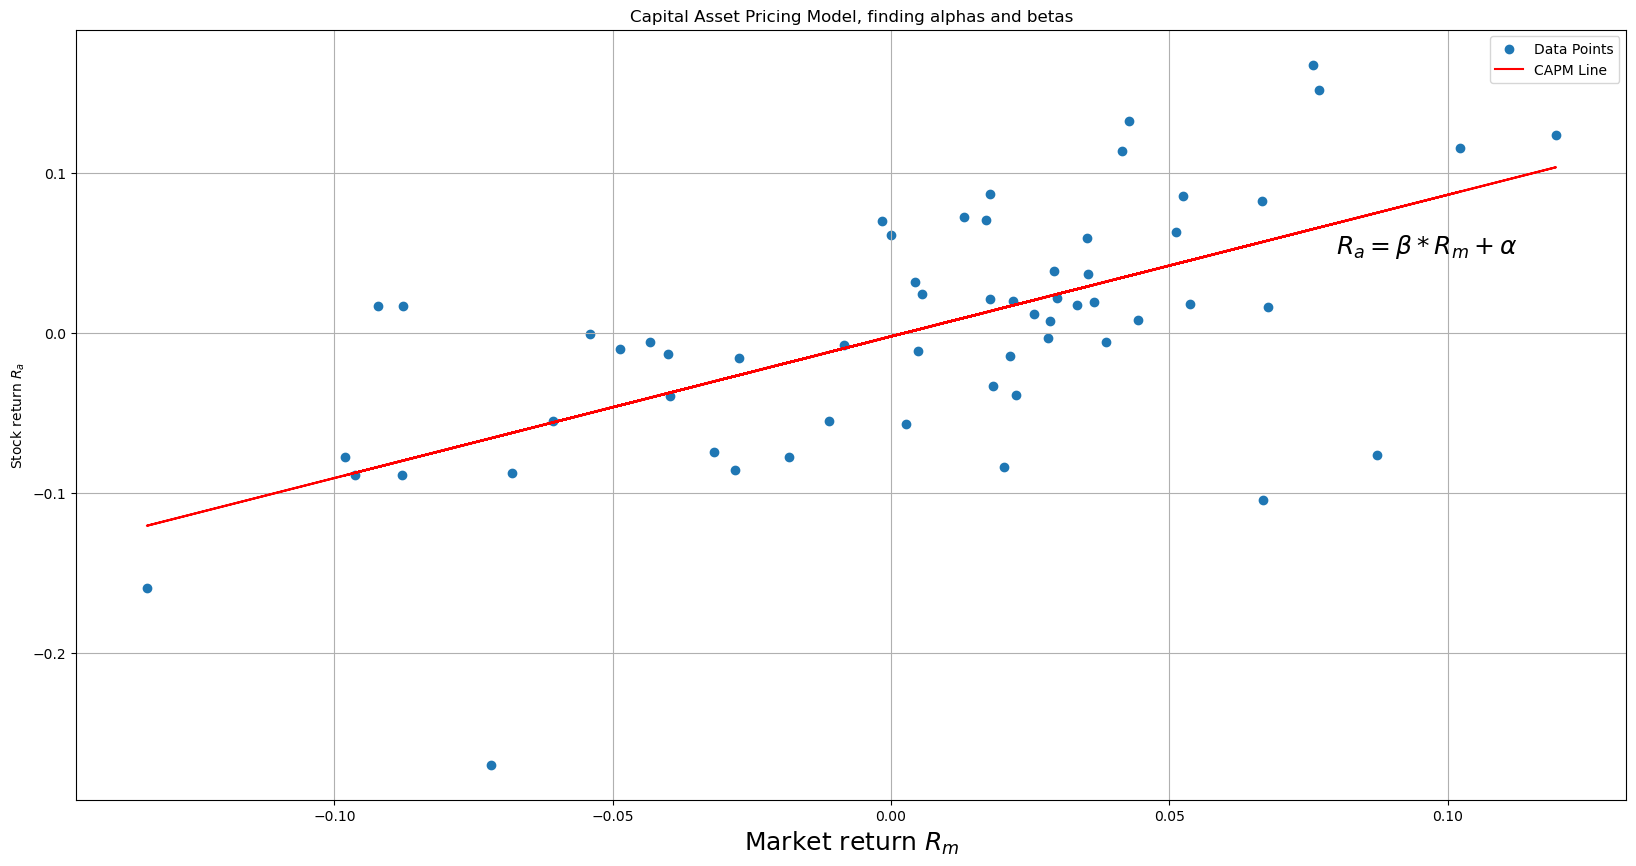

In [9]:
class CAPM:
    
    def __init__(self, stocks, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date
        
    def download_data(self):
        
        data ={}
        
        for stock in self.stocks:
            ticker = yf.download(stock, self.start_date, self.end_date)
            data[stock] = ticker ['Adj Close']
            
        return pd.DataFrame(data)
    
    def initialize(self):
        
        stock_data = self.download_data()
        # we use monthly returns instead of daily returns
        stock_data = stock_data.resample('M').last()
        
        self.data = pd.DataFrame({'s_adjclose':stock_data[self.stocks[0]],
                                  'm_adjclose':stock_data[self.stocks[1]]})
        
        # logarithmic monthly returns
        self.data[['s_returns','m_returns']] = np.log(self.data[['s_adjclose','m_adjclose']]/
                                                     self.data[['s_adjclose','m_adjclose']].shift(1))
        
        # remove the NaN values
        self.data = self.data[1:]
        
    def calculate_beta(self):
        # covariance matrix: the diagonal items are the variances
        # off diagonals are the covariances
        # the matrix is symmetric: cov[0,1] = cov[1,0] !!!
        covariance_matrix = np.cov(self.data["s_returns"], self.data["m_returns"])
        # calculating beta according to the formula
        beta = covariance_matrix[0,1] / covariance_matrix[1,1]
        print("Beta from formula", beta)
        
    def regression(self):
        # using linear regression to fit a line to the dat
        # [stock_returns, market_returns] - slope is the beta
        beta, alpha = np.polyfit(self.data['m_returns'], self.data['s_returns'], deg=1)
        print("Beta from regression: ", beta)
        # calculate the expected return according to the CAPM formula
        # we are after annual returns (and hence we multipy by 12)
        expected_return = RISK_FREE_RATE + beta * (self.data['m_returns'].mean()*MONTHS_IN_YEAR - RISK_FREE_RATE)
        print("Expected return:", expected_return)
        self.plot_regression(alpha, beta)
        
    def plot_regression(self, alpha, beta):
        fig, axis = plt.subplots(1, figsize=(20,10))
        axis.scatter(self.data["m_returns"], self.data['s_returns'], label="Data Points")
        axis.plot(self.data["m_returns"], beta * self.data["m_returns"] + alpha, color='red', label='CAPM Line')
        plt.title('Capital Asset Pricing Model, finding alphas and betas')
        plt.xlabel('Market return $R_m$', fontsize=18)
        plt.ylabel('Stock return $R_a$')
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show
        
if __name__ == '__main__':
    
    capm = CAPM(['IBM','^GSPC'],'2018-01-01', '2023-01-01')
    capm.initialize()
    capm.calculate_beta()
    capm.regression()

The portfolio is less risky, and hence has less return, than the market since our beta value indicates the stock market risk is lower than that of an average stock.

## Normal distribution of returns

[*********************100%***********************]  1 of 1 completed


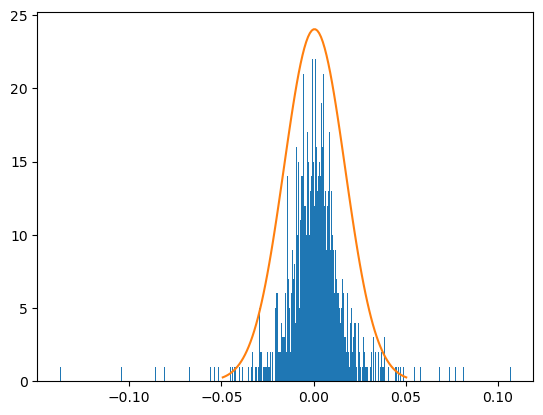

In [14]:
def download_data(stock, start_date, end_date):
    data = {}
    ticker = yf.download(stock, start_date, end_date)
    data['Price'] = ticker['Adj Close']
    return pd.DataFrame(data)

def calculate_returns(stock_data):
    stock_data['Price'] = np.log(stock_data['Price'] / stock_data['Price'].shift(1))
    return stock_data[1:]

# the fat tails mean that extreme events occur more frequently in reality than what a normal distribution would predict
def show(stock_data):
    plt.hist(stock_data, bins=700)
    stock_variance = stock_data.var()
    stock_mean = stock_data.mean()
    sigma = np.sqrt(stock_variance)
    x = np.linspace(stock_mean - 3 * sigma, stock_mean + 3 * sigma, 100)
    plt.plot(x, norm.pdf(x, stock_mean, sigma))
    plt.show()
    
    
if __name__ == "__main__":
    stock_data = download_data('IBM', '2019-01-01', '2024-01-01')
    show(calculate_returns(stock_data))

# Wiener Process

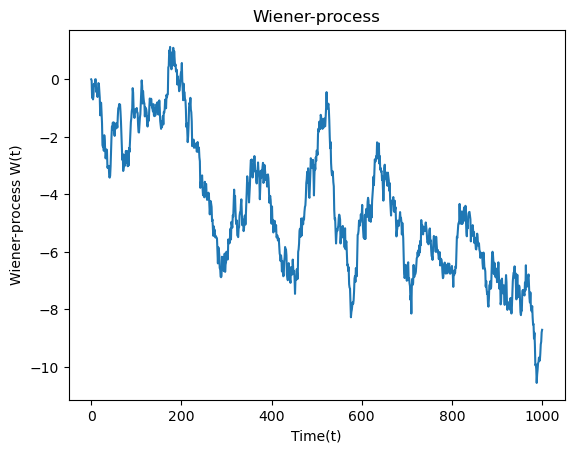

In [16]:
def wiener_process(dt=0.1, x0=0, n=1000):
    # W(t=0)=0
    # initialize W(t) with zeros
    W = np.zeros(n+1)
    # we create N+1 timesteps: t=0,1,2,3,...,N
    t = np.linspace(x0, n, n+1)
    # We have to use the cumulative sum: on every step the additional value is drawn from a normal distribution with mean 0 and variance dt
    # N(0,dt)= sqrt(dt)*N(0,1) usually this formula is used
    W[1:n+1] = np.cumsum(np.random.normal(0, np.sqrt(dt), n))
    
    return t, W

def plot_process(t, W):
    plt.plot(t, W)
    plt.xlabel('Time(t)')
    plt.ylabel('Wiener-process W(t)')
    plt.title('Wiener-process')
    plt.show()
    
if __name__ == '__main__':
    time, data = wiener_process()
    plot_process(time, data)
    

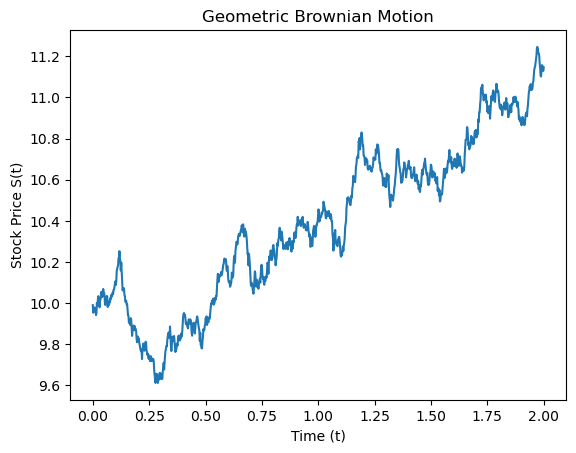

In [18]:
def simulate_geometric_random_walk(S0, T=2, N=1000, mu=0.1, sigma=0.05):
    dt = T / N
    t = np.linspace(0, T, N)
    # standard normal distribution N(0,1)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)
    X = (mu - 0.5 * sigma ** 2) * t + sigma * W
    S = S0 * np.exp(X)
    
    return t, S

def plot_simulation(t, S):
    plt.plot(t, S)
    plt.xlabel('Time (t)')
    plt.ylabel('Stock Price S(t)')
    plt.title('Geometric Brownian Motion')
    plt.show()
    
if __name__ == '__main__':
    
    time, data = simulate_geometric_random_walk(10)
    plot_simulation(time, data)

# Black-Scholes Model

In [20]:
def call_option_price(S, E, T, rf, sigma):
    # first we calculate the d1 and d2 parameters
    d1 = (log(S/E)+(rf+sigma*sigma/2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    print("The d1 and d2 parameters: %s, %s" % (d1, d2))
    # use N(x) to calculate the option price
    return S*stats.norm.cdf(d1)-E*exp(-rf*T)*stats.norm.cdf(d2)

def put_option_price(S, E, T, rf, sigma):
    # first we calculate the d1 and d2 parameters
    d1 = (log(S/E)+(rf+sigma*sigma/2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    print("The d1 and d2 parameters: %s, %s" % (d1, d2))
    # use N(x) to calculate the option price
    return -S*stats.norm.cdf(-d1)+E*exp(-rf*T)*stats.norm.cdf(-d2)

if __name__ == '__main__':
    # underlying stock price at t=0
    S0 = 100
    # strike price
    E = 100
    # expiry 1 year = 365 days
    T = 1
    # risk-free rate
    rf = 0.05
    # volatility of the underlying stock
    sigma = 0.2
    print("Call option price according to Black-Scholes model: ", call_option_price(S0, E, T, rf, sigma))
    print("Put option price according to Black-Scholes model: ", put_option_price(S0, E, T, rf, sigma))

The d1 and d2 parameters: 0.35000000000000003, 0.15000000000000002
Call option price according to Black-Scholes model:  10.450583572185565
The d1 and d2 parameters: 0.35000000000000003, 0.15000000000000002
Put option price according to Black-Scholes model:  5.573526022256971


## Monte-Carlo simulation

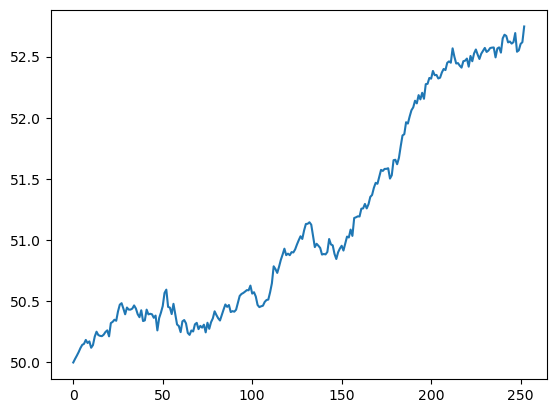

Prediction for future stock price: $52.75


In [25]:
NUM_OF_SIMULATIONS = 100

def stock_monte_carlo(S0, mu, sigma, N=252):
    
    result = []
    
    # number of simulations - possible S(t) realizations (of the process)
    for _ in range(NUM_OF_SIMULATIONS):
        prices = [S0]
        for _ in range (N):
            # we simulate the change day-by-day (t=1)
            stock_price = prices[-1] * np.exp((mu - 0.5 * sigma **2) + sigma * np.random.normal())
            prices.append(stock_price)
            
        result.append(prices)
        
    simulation_data = pd.DataFrame(result)
    # the given columns will contain the time series for a given simulation
    simulation_data = simulation_data.T
    
    simulation_data['mean'] = simulation_data.mean(axis=1)
    
    plt.plot(simulation_data['mean'])
    plt.show()
    
    print('Prediction for future stock price: $%.2f' % simulation_data['mean'].tail(1))
    
if __name__ == '__main__':
    stock_monte_carlo(50, 0.0002, 0.01)

In [10]:
class OptionPricing:
    def __init__(self, S0, E, T, rf, sigma, iterations):
        self.S0 = S0
        self.E = E
        self.T = T
        self.rf = rf
        self.sigma = sigma
        self.iterations = iterations
        
    def call_option_simulation(self):
        # we have 2 columns: first with 0s, the second will the payoff (function is max(0,S-E) for call option)
        option_data = np.zeros([self.iterations, 2])
        
        # dimensions: 1 dimensional array with as many items as the iterations
        rand = np.random.normal(0, 1, [1, self.iterations])
        
        # equation for the S(t) stock price at T
        stock_price = self.S0 * np.exp(self.T * (self.rf - 0.5 * self.sigma ** 2) + self.sigma * np.sqrt(self.T) * rand)
        
        # we need S-E since we have to calculate max(S-E,0)
        option_data[:, 1] = stock_price - self.E
        
        # average for the Monte-Carlo simulation
        # max() returns the max(S-E) according to the formula
        average = np.sum(np.amax(option_data, axis=1)) / float(self.iterations)
        
        # we have to use the exp(-rT) discount factor
        return np.exp(-1.0*self.rf*self.T)*average
    
    def put_option_simulation(self):
        # we have 2 columns: first with 0s, the second will the payoff (function is max(0,S-E) for call option)
        option_data = np.zeros([self.iterations, 2])
        
        # dimensions: 1 dimensional array with as many items as the iterations
        rand = np.random.normal(0, 1, [1, self.iterations])
        
        # equation for the S(t) stock price at T
        stock_price = self.S0 * np.exp(self.T * (self.rf - 0.5 * self.sigma ** 2) + self.sigma * np.sqrt(self.T) * rand)
        
        # we need S-E since we have to calculate max(E-S,0)
        option_data[:, 1] = self.E - stock_price
        
        # average for the Monte-Carlo simulation
        # max() returns the max(S-E) according to the formula
        average = np.sum(np.amax(option_data, axis=1)) / float(self.iterations)
        
        # we have to use the exp(-rT) discount factor
        return np.exp(-1.0*self.rf*self.T)*average
        
if __name__ == '__main__':
    model = OptionPricing(100, 100, 1, 0.05, 0.2, 10000)
    print('Value of the call option is $%.2f' % model.call_option_simulation())
    print('Value of the put option is $%.2f' % model.put_option_simulation())

Value of the call option is $10.79
Value of the put option is $5.43


# Value at Risk

In [17]:
def download_data(stock, start_date, end_date):
    data = {}
    ticker = yf.download(stock, start_date, end_date)
    data[stock] = ticker['Adj Close']
    return pd.DataFrame(data)

# calculate the VaR tomorrow (n=1)
def calculate_var(position, c, mu, sigma):
    var = position * (mu - sigma*norm.ppf(1-c))
    return var

# calculate the VaR for n days in the future
def calculate_var_n(position, c, mu, sigma, n):
    var = position * (mu * n - sigma * np.sqrt(n) * norm.ppf(1-c))
    return var

if __name__ == '__main__':
    
    start = datetime.datetime(2020, 1, 1)
    end = datetime.datetime(2024, 1, 1)
    
    #Citigroup
    stock_data = download_data('C', start, end)
    
    stock_data['returns'] = np.log(stock_data['C'] / stock_data['C'].shift(1))
    stock_data = stock_data[1:]
    print(stock_data)
    
    # investment (e.g. 1 million dollars in stocks)
    S = 1e6
    # confidence level of 99%
    c = 0.99
    
    # assume daily returns are normally distributed
    mu = np.mean(stock_data['returns'])
    sigma = np.std(stock_data['returns'])
    
    print('Value at risk is: $%0.2f' % calculate_var_n(S, c, mu, sigma, 10))

[*********************100%***********************]  1 of 1 completed
                    C   returns
Date                           
2020-01-03  67.664703 -0.019015
2020-01-06  67.452477 -0.003141
2020-01-07  66.866676 -0.008723
2020-01-08  67.376068  0.007589
2020-01-09  67.987350  0.009032
...               ...       ...
2023-12-22  50.379162  0.005125
2023-12-26  50.854626  0.009393
2023-12-27  50.973488  0.002335
2023-12-28  51.032925  0.001165
2023-12-29  50.953678 -0.001554

[1005 rows x 2 columns]
Value at risk is: $191024.15


In [19]:
def download_data(stock, start, end):
    data = {}
    ticker = yf.download(stock, start, end)
    data['Adj Close'] = ticker['Adj Close']
    return pd.DataFrame(data)

class ValueAtRiskMonteCarlo:
    
    def __init__(self, S, mu, sigma, c, n, iterations):
        # value of investment at t=0
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.c = c
        self.n = n
        self.iterations = iterations
        
    def simulation(self):
        rand = np.random.normal(0, 1, [1, self.iterations])
        
        # equation for the S(t) stock price
        # random walk of initial investment
        stock_price = self.S * np.exp(self.n * (self.mu - 0.5 * self.sigma ** 2) + self.sigma * np.sqrt(self.n) * rand)
        
        # sort stock prices to determine percentile
        stock_price = np.sort(stock_price)
        
        # depends on confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price, (1 - self.c) * 100)
        
        return self.S - percentile
        
if __name__ == '__main__':
    
    # investment
    S = 1e6
    # confidence level of 95%
    c = 0.95
    # 1 day
    n = 1
    # number of paths in the Monte-Carlo simulation
    iterations = 100000
    
    # historical data to approximate mean and standard deviation
    start_date = datetime.datetime(2020, 1, 1)
    end_date = datetime.datetime(2024, 1, 1)
    
    # download stock related data from Yahoo Finance
    citi = download_data('C', start_date, end_date)
    
    # calculate daily returns
    citi['returns'] = citi['Adj Close'].pct_change()
    
    # assume daily returns are normally distributed
    mu = np.mean(citi['returns'])
    sigma = np.std(citi['returns'])
    
    model = ValueAtRiskMonteCarlo(S, mu, sigma, c, n, iterations)
    print('Value at risk with Monte-Carlo simulation: $%0.2f' % model.simulation())

[*********************100%***********************]  1 of 1 completed
Value at risk with Monte-Carlo simulation: $42600.02


# Ornstein-Uhlenbeck Process

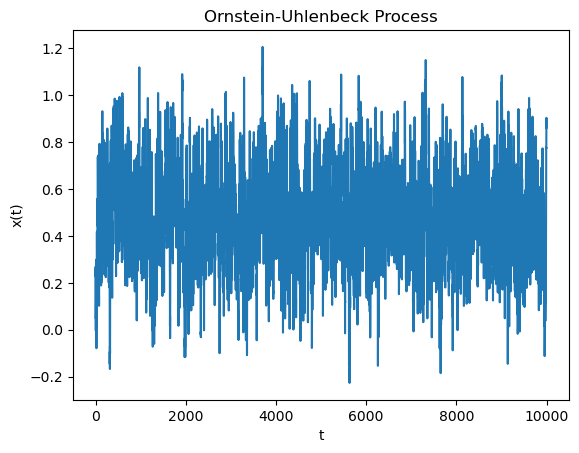

In [21]:
def generate_process(dt=0.1, theta=1.2, mu=0.5, sigma=0.3, n=10000):
    # x(t=0)=0 and initialize x(t) with zeros
    x = np.zeros(n)
    
    for t in range(1, n):
        x[t] = x[t-1] + theta*(mu-x[t-1])*dt + sigma * normal(0, np.sqrt(dt))
        
    return x

def plot_process(x):
    plt.plot(x)
    plt.xlabel('t')
    plt.ylabel('x(t)')
    plt.title('Ornstein-Uhlenbeck Process')
    plt.show()
    
if __name__ == '__main__':
    data = generate_process()
    plot_process(data)